# Tidying the data

Previously we saw several issues with the data:
3. There are 5 classes instead of 3.
4. Outlier for one sepal_width_cm entry.
5. Several sepal_length_cm entries for `Iris-versicolor` are near-zero for some reason.
2. 5 missing values in the petal_width_cm column

Let's walk through the issues one-by-one.

### Issue 1: There are 5 classes instead of 3.

After talking with the field researchers, it sounds like one of them forgot to add `Iris-` before their `Iris-versicolor` entries. The other extraneous class, `Iris-setossa`, was simply a typo that they forgot to fix.

Let's use the DataFrame to fix these errors.

In [1]:
import pandas as pd
iris_data = pd.read_csv('../data/iris-data.csv', na_values=['NA'])

iris_data.loc[iris_data['class'] == 'versicolor', 'class'] = 'Iris-versicolor'
iris_data.loc[iris_data['class'] == 'Iris-setossa', 'class'] = 'Iris-setosa'

iris_data['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

### Issue 2: Outlier for one sepal_width_cm entry.

Our field researchers know that it's impossible for `Iris-setosa` to have a sepal width below 2.5 cm. Clearly this entry was made in error, and we're better off just scrapping the entry than spending hours finding out what happened.

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


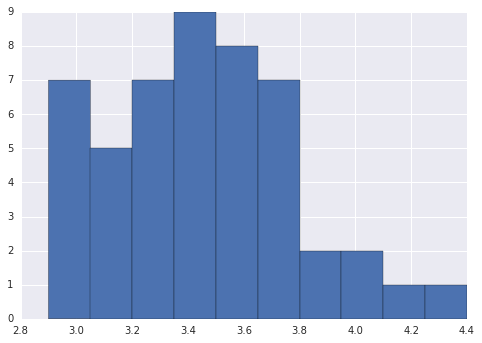

In [4]:
# This line tells the notebook to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

# This line drops any 'Iris-setosa' rows with a separal width less than 2.5 cm
iris_data = iris_data.loc[(iris_data['class'] != 'Iris-setosa') | (iris_data['sepal_width_cm'] >= 2.5)]
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'sepal_width_cm'].hist()

Now all of our Iris-setosa rows have a sepal width greater than 2.5.

### Issue 3: Several sepal_length_cm entries for `Iris-versicolor` are near-zero for some reason



In [6]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
77,0.067,3.0,5.0,1.7,Iris-versicolor
78,0.060,2.9,4.5,1.5,Iris-versicolor
79,0.057,2.6,3.5,1.0,Iris-versicolor
80,0.055,2.4,3.8,1.1,Iris-versicolor
81,0.055,2.4,3.7,1.0,Iris-versicolor


All of these near-zero `sepal_length_cm` entries seem to be off by two orders of magnitude, as if they had been recorded in meters instead of centimeters.

After some brief correspondence with the field researchers, we find that one of them forgot to convert those measurements to centimeters. We correct these for them.

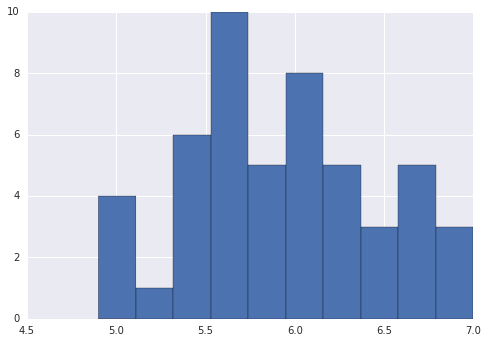

In [7]:
iris_data.loc[(iris_data['class'] == 'Iris-versicolor') &
              (iris_data['sepal_length_cm'] < 1.0),
              'sepal_length_cm'] *= 100.0

iris_data.loc[iris_data['class'] == 'Iris-versicolor', 'sepal_length_cm'].hist()

### Issue 4: 5 missing values in the `petal_width_cm` column


In [8]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
7,5.0,3.4,1.5,NaN,Iris-setosa
8,4.4,2.9,1.4,NaN,Iris-setosa
9,4.9,3.1,1.5,NaN,Iris-setosa
10,5.4,3.7,1.5,NaN,Iris-setosa
11,4.8,3.4,1.6,NaN,Iris-setosa


Since it seems like the missing data is systematic — all of the missing values are in the same column for the same Iris type — this error could potentially bias our analysis. If we drop all of these, we would rob the Iris-setosa class of some important training data on the other features.

We will apply mean imputation: If we know that the values for a measurement fall in a certain range, we can fill in empty values with the average of that measurement.

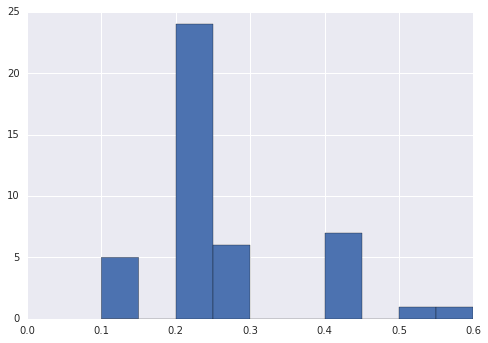

In [9]:
iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].hist()

Most of the petal widths for `Iris-setosa` fall within the 0.2-0.3 range, so it feelrelatively safe to fill in these entries with the average measured petal width. 

In [10]:
average_petal_width = iris_data.loc[iris_data['class'] == 'Iris-setosa', 'petal_width_cm'].mean()

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'].isnull()),
              'petal_width_cm'] = average_petal_width

iris_data.loc[(iris_data['class'] == 'Iris-setosa') &
              (iris_data['petal_width_cm'] == average_petal_width)]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
7,5.0,3.4,1.5,0.25,Iris-setosa
8,4.4,2.9,1.4,0.25,Iris-setosa
9,4.9,3.1,1.5,0.25,Iris-setosa
10,5.4,3.7,1.5,0.25,Iris-setosa
11,4.8,3.4,1.6,0.25,Iris-setosa


Confirming that all NAs are filled in with mean values:

In [11]:
iris_data.loc[(iris_data['sepal_length_cm'].isnull()) |
              (iris_data['sepal_width_cm'].isnull()) |
              (iris_data['petal_length_cm'].isnull()) |
              (iris_data['petal_width_cm'].isnull())]

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class


**Note for future:** Another option is to drop all rows with missing data with the `dropna()` call:

    iris_data.dropna(inplace=True)

## Save the cleaned data

In [12]:
iris_data.to_csv('../data/iris-data-clean.csv', index=False)

iris_data_clean = pd.read_csv('../data/iris-data-clean.csv')

Look at the cleaned data in scatter matrix plot:

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


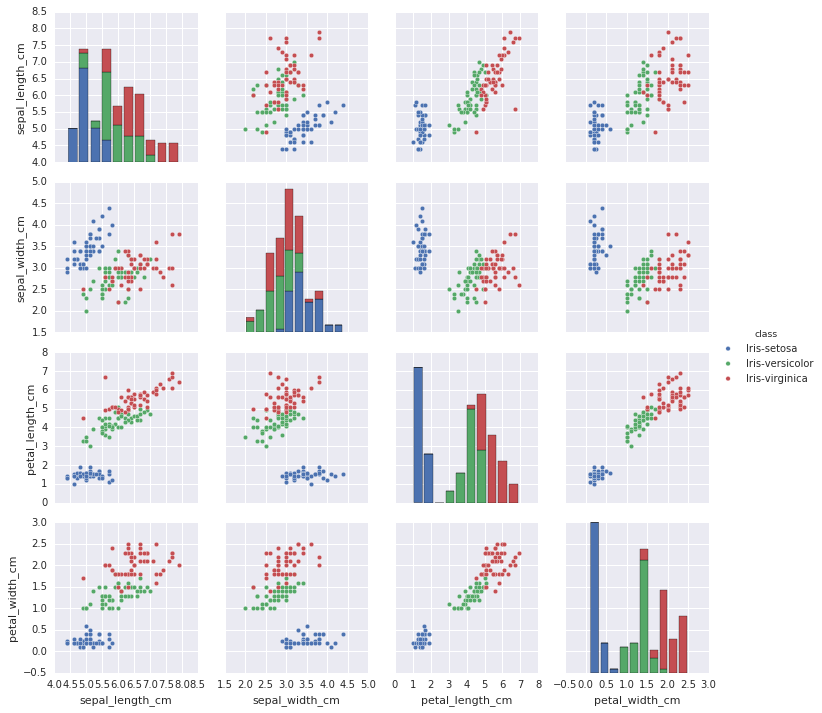

In [13]:
sb.pairplot(iris_data_clean, hue='class')

Looks good!

# Summary
1. Fixed all issues initiall discovered with the data in the Checking the Data.ipynb
2. Cleaned dataset is now available at `data/iris-data-clean.csv`.